In [1]:
import os 
import sys
sys.path.append('C:/Users/yl0768/AppData/Roaming/Python/Python311/site-packages')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from sklearn.model_selection import train_test_split
import pickle

import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

In [2]:
import sys
sys.path.append(r'C:\Users\14369\Downloads\project-main (1)\project-main\venv\Lib\site-packages')
import pandas as pd

In [3]:
transform = transforms.Compose( # Doing transforms
    [transforms.ToTensor(), # to tensor object
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]) # mean = 0.5, std = 0.5

In [4]:
from torch.utils.data import Dataset
from PIL import Image

class CustomImageDataset(Dataset):
    def __init__(self, annotations_file, img_dir, transform=None):
        self.img_labels = pd.read_csv(annotations_file)
        self.img_dir = img_dir
        self.transform = transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0]+'.tif')
        image = Image.open(img_path)
        label = self.img_labels.iloc[idx, 1]
        if self.transform:
            image = self.transform(image)
        return image, label
train_data = CustomImageDataset(
    annotations_file='./histopathologic-cancer-detection/train_labels.csv',
    img_dir='./histopathologic-cancer-detection/train',
    transform=transform
)
train_loader = DataLoader(train_data, batch_size=32, shuffle=True)

In [5]:
batch_size = 32
img_height = 180
img_width = 180

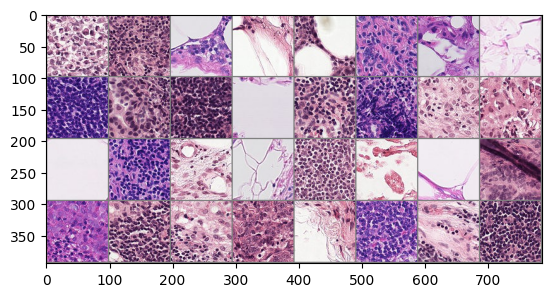

1     0     0     0     1     1     1     0     0     1     0     0     0     0     1     1     0     0     0     0     0     0     0     1     1     0     0     1     0     0     0     0    


In [6]:
classes = ('0', '1')
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(train_loader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

In [7]:
from torch.utils.data import random_split
torch.manual_seed(12345)
total_size = len(train_data)
print("total size =",total_size)
train_size = int(total_size * 0.7)
test_size = int(total_size * 0.15)
val_size = total_size - train_size - test_size
train_dataset, val_dataset, test_dataset = random_split(train_data, [train_size, test_size, val_size])
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
print("train size=",len(train_dataset))

total size = 220025
train size= 154017


In [8]:
# Place this function at the beginning of your notebook
def conv_output_size(input_size, filter_size, stride=1, padding=0, pool_filter=2, pool_stride=2):
    output_size = (input_size - filter_size + 2 * padding) / stride + 1
    output_size = (output_size - pool_filter) / pool_stride + 1
    return int(output_size)

# Use the function to calculate the input size for fc1
input_size = 180  # Assuming this is your image size
size_after_first_layer = conv_output_size(input_size, 5)
size_after_second_layer = conv_output_size(size_after_first_layer, 5)

# Update this value in your Net class
fc1_input_size = 16 * size_after_second_layer * size_after_second_layer

In [9]:
class Net(nn.Module):
    ''' Models a simple Convolutional Neural Network'''

    def __init__(self):
        ''' initialize the network '''
        super(Net, self).__init__()
        # 3 input image channel, 6 output channels, 5x5 square convolution kernel
        self.conv1 = nn.Conv2d(3, 6, 5)
        # Max pooling over a (2, 2) window
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        # Corrected input size for the first fully connected layer
        self.fc1 = nn.Linear(16 * 21 * 21, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 2)  # Two output units for binary classification

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(wx)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 21 * 21)  # Corrected view operation
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

net = Net()
class double_conv2d_bn(nn.Module):
    def __init__(self,in_channels,out_channels,kernel_size=3,strides=1,padding=1):
        super(double_conv2d_bn,self).__init__()
        self.conv1 = nn.Conv2d(in_channels,out_channels,
                               kernel_size=kernel_size,
                              stride = strides,padding=padding,bias=True)
        self.conv2 = nn.Conv2d(out_channels,out_channels,
                              kernel_size = kernel_size,
                              stride = strides,padding=padding,bias=True)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.bn2 = nn.BatchNorm2d(out_channels)
    
    def forward(self,x):
        # print(' def forward(self,x):', x.shape)
        out = F.relu(self.bn1(self.conv1(x)))
        out = F.relu(self.bn2(self.conv2(out)))
        return out
    
class deconv2d_bn(nn.Module):
    def __init__(self,in_channels,out_channels,kernel_size=2,strides=2):
        super(deconv2d_bn,self).__init__()
        self.conv1 = nn.ConvTranspose2d(in_channels,out_channels,
                                        kernel_size = kernel_size,
                                       stride = strides,bias=True)
        self.bn1 = nn.BatchNorm2d(out_channels)
        
    def forward(self,x):
        out = F.relu(self.bn1(self.conv1(x)))
        return out




class SCConv(nn.Module):
    def __init__(self, input_channel, output_channel,control_conv_kernel_size):
        super(SCConv, self).__init__()
        # Define your custom layer operations here
        # For example, create two parallel channels
        self.input_channel = input_channel
        self.output_channel = output_channel
        self.process_conv = nn.Conv2d(self.input_channel,self.output_channel, kernel_size=3,padding=1)  # First channel
        self.control_conv = nn.Conv2d(self.input_channel,self.output_channel, kernel_size=control_conv_kernel_size)  # First channel
        
        
    def forward(self, x):
        # Pass input through both channels
        # print('x.shape',x.shape)
        output1 = self.process_conv(x)
        # print('output1.shape', output1.shape)
       
        output2 = self.control_conv(x)
        # print('output2.shape', output2.shape)

        # Apply step function (threshold at 0)
        output2 = torch.where(output2 >= 0, torch.tensor(1.0), torch.tensor(0.0))
        # Element-wise multiplication of the two channel outputs
        multiplied_output = torch.mul(output1, output2)
        
        # print('multiplied_output.shape', output1.shape)
        return multiplied_output





class Unet(nn.Module):
    def __init__(self):
        super(Unet,self).__init__()
        self.layer1_conv = double_conv2d_bn(3,8)
        self.layer2_conv = double_conv2d_bn(8,16)
        self.SCConv1 = SCConv(16,16,24)
        
        self.layer3_conv = double_conv2d_bn(16,32)
        self.layer4_conv = double_conv2d_bn(32,64)
        self.SCConv2 = SCConv(64,64,6)
        
        self.layer5_conv = double_conv2d_bn(64,128)
        self.layer6_conv = double_conv2d_bn(128,64)
        self.SCConv3 = SCConv(64,64,12)
        
        self.layer7_conv = double_conv2d_bn(64,32)
        self.layer8_conv = double_conv2d_bn(32,16)
        self.SCConv4 = SCConv(16,16,48)
        
        self.layer9_conv = double_conv2d_bn(16,8)
        self.layer10_conv = nn.Conv2d(8,1,kernel_size=3,
                                     stride=1,padding=1,bias=True)
        
        self.deconv1 = deconv2d_bn(128,64)
        self.deconv2 = deconv2d_bn(64,32)
        self.deconv3 = deconv2d_bn(32,16)
        self.deconv4 = deconv2d_bn(16,8)
        self.fc1 = nn.Linear(9216, 2)
        self.sigmoid = nn.Sigmoid()
        
    def forward(self,x):
        conv1 = self.layer1_conv(x)
        pool1 = F.max_pool2d(conv1,2)
        
        conv2 = self.layer2_conv(pool1)
        pool2 = F.max_pool2d(conv2,2)
        SCConv1_out = self.SCConv1(pool2)
        
        conv3 = self.layer3_conv(SCConv1_out)
        pool3 = F.max_pool2d(conv3,2)
        
        conv4 = self.layer4_conv(pool3)
        pool4 = F.max_pool2d(conv4,2)
        SCConv2_out = self.SCConv2(pool4)
        
        conv5 = self.layer5_conv(SCConv2_out)
        
        convt1 = self.deconv1(conv5)
        concat1 = torch.cat([convt1,conv4],dim=1)
        conv6 = self.layer6_conv(concat1)
        SCConv3_out = self.SCConv3(conv6)
        
        convt2 = self.deconv2(SCConv3_out)
        concat2 = torch.cat([convt2,conv3],dim=1)
        conv7 = self.layer7_conv(concat2)
       
        convt3 = self.deconv3(conv7)
        concat3 = torch.cat([convt3,conv2],dim=1)
        conv8 = self.layer8_conv(concat3)
        SCConv4_out = self.SCConv4(conv8)
        
        convt4 = self.deconv4(SCConv4_out)
        concat4 = torch.cat([convt4,conv1],dim=1)
        conv9 = self.layer9_conv(concat4)
        outp = self.layer10_conv(conv9)
        outp = self.sigmoid(outp)
        outp = outp.view(outp.size(0), -1)
        outp = self.fc1(outp)
        return outp
   
model =  Unet()
for name, layer in model.named_modules():
    print(f"Layer name: {name}")

Layer name: 
Layer name: layer1_conv
Layer name: layer1_conv.conv1
Layer name: layer1_conv.conv2
Layer name: layer1_conv.bn1
Layer name: layer1_conv.bn2
Layer name: layer2_conv
Layer name: layer2_conv.conv1
Layer name: layer2_conv.conv2
Layer name: layer2_conv.bn1
Layer name: layer2_conv.bn2
Layer name: SCConv1
Layer name: SCConv1.process_conv
Layer name: SCConv1.control_conv
Layer name: layer3_conv
Layer name: layer3_conv.conv1
Layer name: layer3_conv.conv2
Layer name: layer3_conv.bn1
Layer name: layer3_conv.bn2
Layer name: layer4_conv
Layer name: layer4_conv.conv1
Layer name: layer4_conv.conv2
Layer name: layer4_conv.bn1
Layer name: layer4_conv.bn2
Layer name: SCConv2
Layer name: SCConv2.process_conv
Layer name: SCConv2.control_conv
Layer name: layer5_conv
Layer name: layer5_conv.conv1
Layer name: layer5_conv.conv2
Layer name: layer5_conv.bn1
Layer name: layer5_conv.bn2
Layer name: layer6_conv
Layer name: layer6_conv.conv1
Layer name: layer6_conv.conv2
Layer name: layer6_conv.bn1
Lay

In [10]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

Unet(
  (layer1_conv): double_conv2d_bn(
    (conv1): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv2): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (bn2): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (layer2_conv): double_conv2d_bn(
    (conv1): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (SCConv1): SCConv(
    (process_conv): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (control_conv): Conv2d(16, 16, kernel_size=(24, 24), stride=(1, 1))
  )
  (layer3_conv): double_conv2d_bn(
    (conv1): Conv2d(16, 3

In [11]:
list_T = [False,True]

for epoch in range(20):  # loop over the dataset multiple times




# Layer name: SCConv1
# Layer name: SCConv1.process_conv
# Layer name: SCConv1.control_conv



    c_true = list_T[(epoch+1)%2]
    out_true = list_T[epoch%2]
    
    # 冻结
    if c_true:
        print('冻结控制层')

        model.SCConv1.control_conv.requires_grad = False
        model.SCConv2.control_conv.requires_grad = False
        model.SCConv3.control_conv.requires_grad = False
        model.SCConv4.control_conv.requires_grad = False

    else:
    # 解冻
        print('解冻控制层')

        model.SCConv1.control_conv.requires_grad = True
        model.SCConv2.control_conv.requires_grad = True
        model.SCConv3.control_conv.requires_grad = True
        model.SCConv4.control_conv.requires_grad = True
        
        
    
    
    if epoch!=0:
        if out_true :
            #冻结
            print('冻结处理层')
            model.SCConv1.process_conv.requires_grad = False
            model.SCConv2.process_conv.requires_grad = False
            model.SCConv3.process_conv.requires_grad = False
            model.SCConv4.process_conv.requires_grad = False
            
        else:
            # 解冻
            print('解冻处理层')
            model.SCConv1.process_conv.requires_grad = True
            model.SCConv2.process_conv.requires_grad = True
            model.SCConv3.process_conv.requires_grad = True
            model.SCConv4.process_conv.requires_grad = True
            
    else:
        print('第0轮输出层不做操作')

    
    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()        
        
        
        # forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        
        # print statistics
        running_loss += loss.item()
        if i % 200 == 199:    # print every 2000 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 200:.3f}')
            running_loss = 0.0

print('Finished Training')

冻结控制层
第0轮输出层不做操作
[1,   200] loss: 0.695
[1,   400] loss: 0.434
[1,   600] loss: 0.424
[1,   800] loss: 0.422
[1,  1000] loss: 0.401
[1,  1200] loss: 0.394
[1,  1400] loss: 0.388
[1,  1600] loss: 0.410
[1,  1800] loss: 0.392
[1,  2000] loss: 0.391
[1,  2200] loss: 0.386
[1,  2400] loss: 0.382
[1,  2600] loss: 0.397
[1,  2800] loss: 0.377
[1,  3000] loss: 0.370
[1,  3200] loss: 0.357
[1,  3400] loss: 0.361
[1,  3600] loss: 0.367
[1,  3800] loss: 0.375
[1,  4000] loss: 0.376
[1,  4200] loss: 0.361
[1,  4400] loss: 0.367
[1,  4600] loss: 0.364
[1,  4800] loss: 0.344
解冻控制层
冻结处理层
[2,   200] loss: 0.350
[2,   400] loss: 0.343
[2,   600] loss: 0.356
[2,   800] loss: 0.351
[2,  1000] loss: 0.340
[2,  1200] loss: 0.341
[2,  1400] loss: 0.338
[2,  1600] loss: 0.352
[2,  1800] loss: 0.342
[2,  2000] loss: 0.339
[2,  2200] loss: 0.327
[2,  2400] loss: 0.339
[2,  2600] loss: 0.321
[2,  2800] loss: 0.344
[2,  3000] loss: 0.342
[2,  3200] loss: 0.322
[2,  3400] loss: 0.332
[2,  3600] loss: 0.331
[2,  

In [12]:
# Specify model name
model_name = "unet+linear_lr001_SCConv20.pth"
# Use torch.save to save the model state
torch.save(model.state_dict(), f'{model_name}')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Accuracy of the network on the test images: 91.96%
Precision: 0.90
Recall: 0.90
F1 Score: 0.90


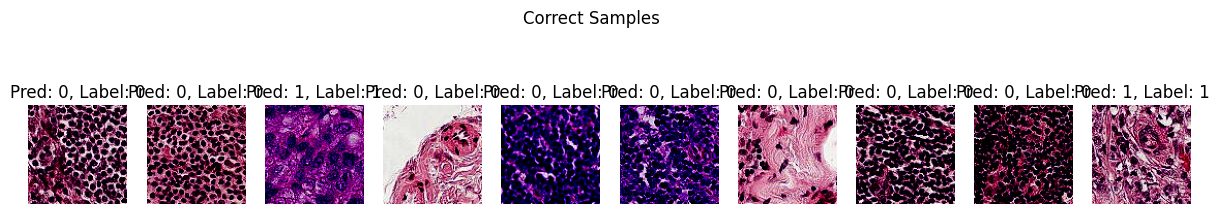

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


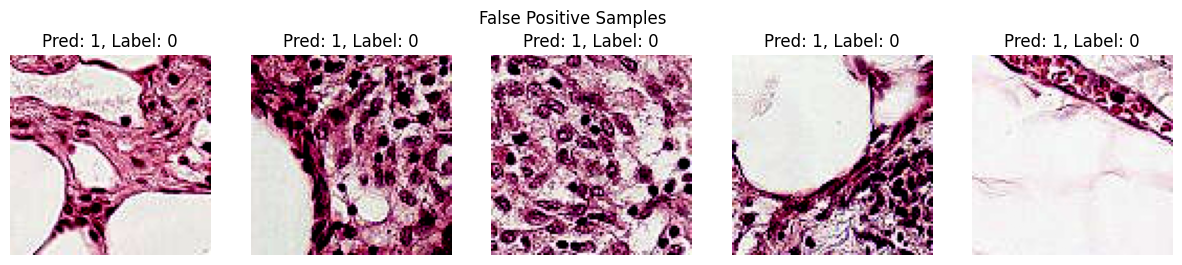

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


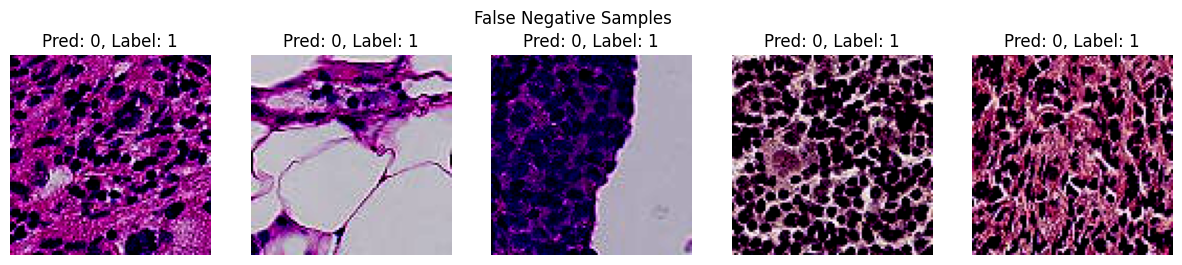

In [13]:
import torch
from torch.utils.data import DataLoader
from torchmetrics import Accuracy, Precision, Recall, F1Score
import matplotlib.pyplot as plt

test_loader = DataLoader(test_dataset, batch_size=32, shuffle=True)
model1 = Unet()
model1.load_state_dict(torch.load('unet+linear_lr001_SCConv20.pth'))
model1.eval()

accuracy = Accuracy(num_classes=1, average='none', task='binary')
precision = Precision(num_classes=1, average='none', task='binary')
recall = Recall(num_classes=1, average='none', task='binary')
f1_score = F1Score(num_classes=1, average='none', task='binary')

# 初始化样本存储列表
correct_samples = []
false_positive_samples = []
false_negative_samples = []

with torch.no_grad():
    for images, labels in test_loader:
        outputs = model1(images)
        _, predicted = torch.max(outputs, 1)

        accuracy.update(predicted, labels)
        precision.update(predicted, labels)
        recall.update(predicted, labels)
        f1_score.update(predicted, labels)


        for img, label, pred in zip(images, labels, predicted):
            if len(correct_samples) < 10 and pred == label:
                correct_samples.append((img, pred, label))
            elif len(false_positive_samples) < 5 and pred == 1 and label == 0:
                false_positive_samples.append((img, pred, label))
            elif len(false_negative_samples) < 5 and pred == 0 and label == 1:
                false_negative_samples.append((img, pred, label))

            # 一旦收集足够的样本，可以提前退出
            if len(correct_samples) >= 10 and len(false_positive_samples) >= 5 and len(false_negative_samples) >= 5:
                break

acc = accuracy.compute()
prec = precision.compute()
rec = recall.compute()
f1 = f1_score.compute()

print(f'Accuracy of the network on the test images: {acc*100:.2f}%')
print(f'Precision: {prec:.2f}')
print(f'Recall: {rec:.2f}')
print(f'F1 Score: {f1:.2f}')


def plot_samples(samples, title):
    fig, axs = plt.subplots(1, len(samples), figsize=(15, 3))
    for i, (img, pred, label) in enumerate(samples):
        axs[i].imshow(img.permute(1, 2, 0).numpy())  
        axs[i].axis('off')
        axs[i].set_title(f'Pred: {pred}, Label: {label}')
    plt.suptitle(title)
    plt.show()

plot_samples(correct_samples, 'Correct Samples')
plot_samples(false_positive_samples, 'False Positive Samples')
plot_samples(false_negative_samples, 'False Negative Samples')
